<a href="https://colab.research.google.com/github/mobinanoorany/Crawling-the-web/blob/main/Week8_SOM_%20NN%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install numpy pandas matplotlib minisom


  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=e780d5a30864a5a59330cdba95962b6473833781688c9b2c1c74ac77d3cebd5a
  Stored in directory: /root/.cache/pip/wheels/96/98/a5/52dee3e8ed1dbfc4d77e4da41b6d89dd7ab9ead1b921e766f8
Successfully built minisom


In [3]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import tensorflow as tf
from minisom import MiniSom
import ast
import matplotlib.pyplot as plt



In [4]:

############################################################################################
image_dir = '/content/drive/MyDrive/Colab Notebooks/downloaded_images'
main_dir = '/content/drive/MyDrive/Colab Notebooks/'
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/image_features_vgg16.csv'
############################################################################################
# Load the CSV file

data = pd.read_csv(csv_file_path)

In [5]:
# Extract filenames and convert stringified lists to actual lists
filenames = data.iloc[:, 0].values
features = data.iloc[:, 1].apply(ast.literal_eval).tolist()
features = np.array(features)

In [6]:
# set parameters for SOM
m = 5
map_size = (m, m)
input_len = features.shape[1]
sigma = 1.0
learning_rate = 0.5
num_epochs = 100

In [7]:
# initialize SOM
som = MiniSom(map_size[0], map_size[1], input_len, sigma=sigma, learning_rate=learning_rate,
              activation_distance='cosine', random_seed=42)
# som.pca_weights_init(features)
som.random_weights_init(features)
# train SOM
som.train_random(features, len(features), verbose=True)
# determine best matching units for each image
bmu_indices = np.array([som.winner(x) for x in features])

 [ 703 / 703 ] 100% - 0:00:00 left 
 quantization error: 606.4661967178909


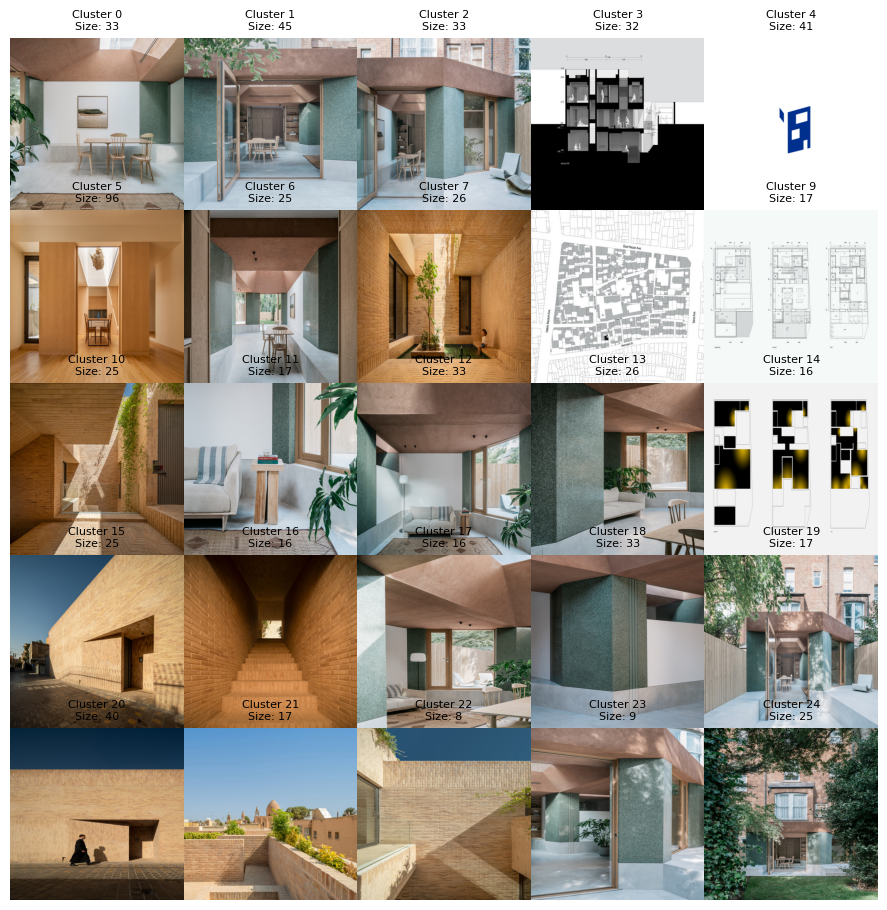

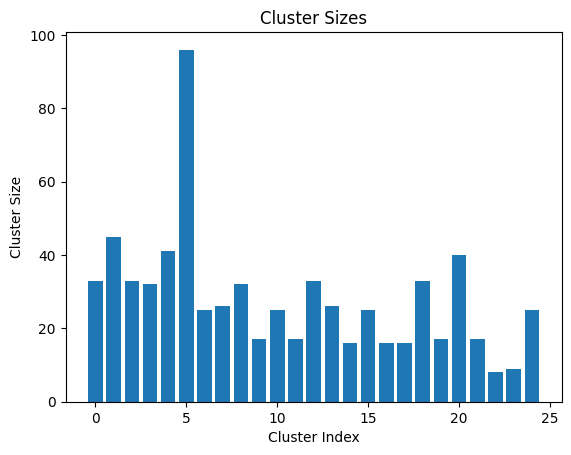

In [8]:

# Define grid size
dpi = 100
subplot_size = 224
figsize = (m * subplot_size / dpi, m * subplot_size / dpi)

# Create a figure with 10x10 subplots
fig, axes = plt.subplots(m, m, figsize=figsize)

# Create a list to keep track of cluster sizes
cluster_sizes = []

# Plot each image in the 10x10 grid
for i in range(m):
    for j in range(m):
        # Get the index of the current SOM node (BMU)
        index = i * m + j

        # Get the list of image indices corresponding to this BMU (i, j)
        bmu_images_indices = [idx for idx, bmu in enumerate(bmu_indices) if tuple(bmu) == (i, j)]

        # Append cluster size to the list
        cluster_sizes.append(len(bmu_images_indices))

        # Plot the first image in the cluster (you can customize this)
        if len(bmu_images_indices) > 0:
            # Load the first image for this BMU
            img_index = bmu_images_indices[0]  # You can loop through all images if needed
            img = Image.open(image_dir + '/' + filenames[img_index])  # Load the image from filename

            # Display the image without black borders and set aspect ratio to 'auto'
            axes[i, j].imshow(img, aspect='auto')
        else:
            # In case of empty clusters, display a placeholder or a message
            axes[i, j].text(0.5, 0.5, "Empty Cluster", ha="center", va="center")

        # Add a title with the cluster index and size
        axes[i, j].set_title(f'Cluster {index}\nSize: {len(bmu_images_indices)}', fontsize=8)

        # Remove the axis ticks for a cleaner look
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

        # Hide borders around the images
        axes[i, j].spines['top'].set_visible(False)
        axes[i, j].spines['right'].set_visible(False)
        axes[i, j].spines['left'].set_visible(False)
        axes[i, j].spines['bottom'].set_visible(False)

# Adjust layout to remove padding between images
plt.subplots_adjust(wspace=0, hspace=0)

# Save the figure to a file
plt.savefig('grid_som_10x10_no_borders.png', bbox_inches='tight', pad_inches=0)

# Visualize cluster sizes as a bar chart
plt.figure()
plt.bar(range(m * m), cluster_sizes)
plt.xlabel('Cluster Index')
plt.ylabel('Cluster Size')
plt.title('Cluster Sizes')
plt.savefig('cluster_sizes.png')

plt.show()


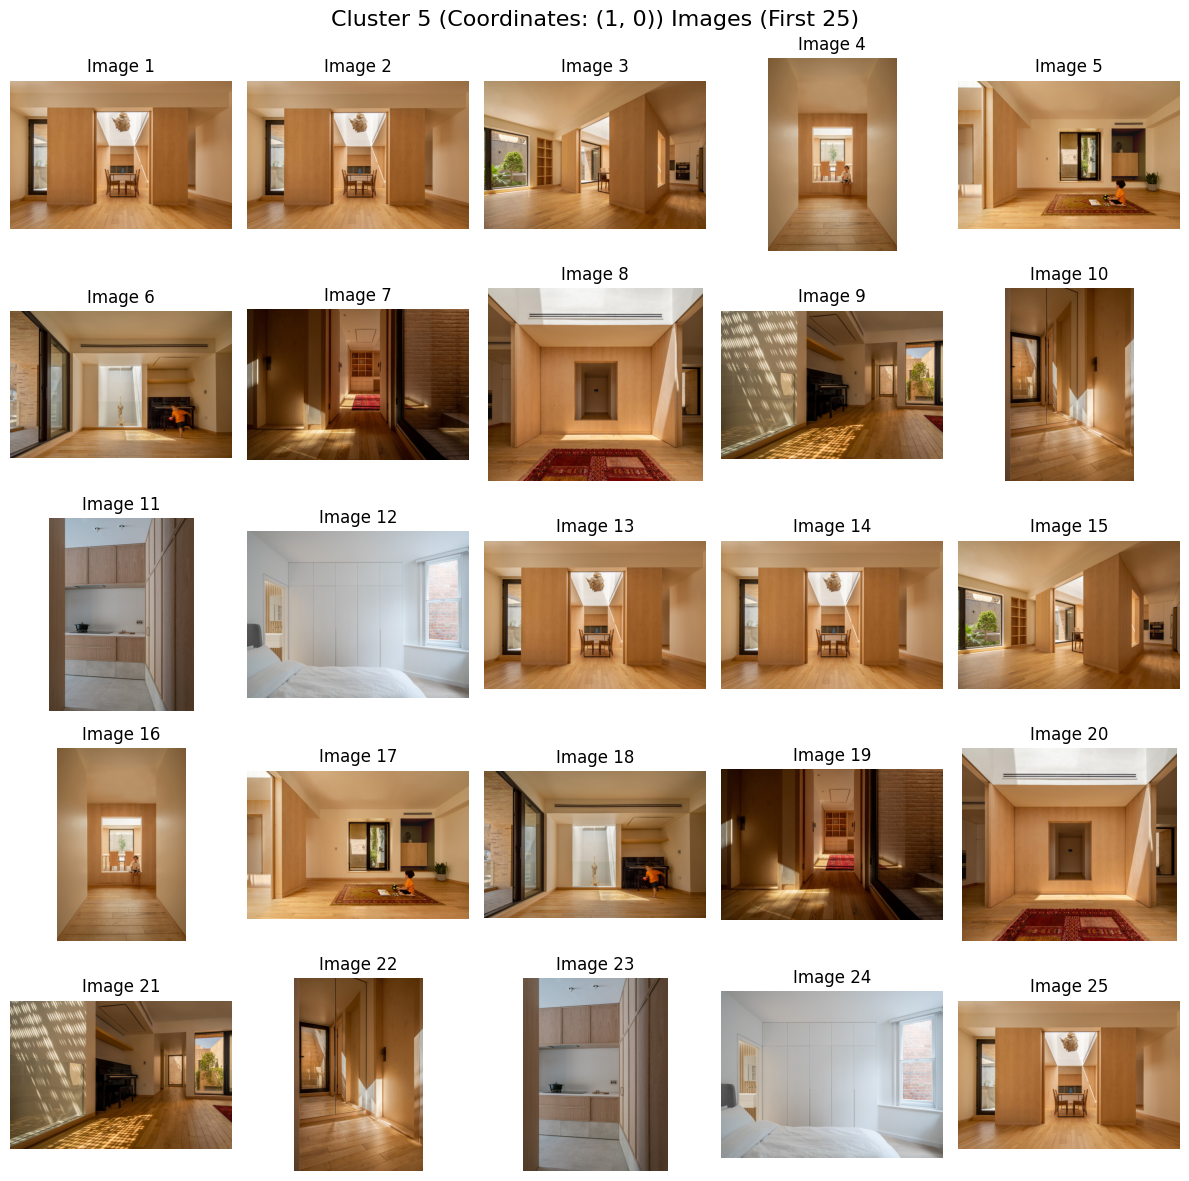

In [9]:
import matplotlib.pyplot as plt
from PIL import Image

# Set the target cluster number (0 to m*m-1)
target_cluster_number = 5  # Change this to the cluster number you want to display



# Convert the target cluster number to BMU coordinates
target_cluster = (target_cluster_number // m, target_cluster_number % m)  # Convert cluster number to (x, y) coordinates

# Find all image indices belonging to the target cluster
cluster_image_indices = [i for i in range(len(bmu_indices)) if tuple(bmu_indices[i]) == target_cluster]

# Check if there are images in the target cluster
if len(cluster_image_indices) == 0:
    # No images in this cluster, display a message
    plt.figure(figsize=(6, 6))
    plt.text(0.5, 0.5, "There are no images in this cluster", ha="center", va="center", fontsize=16)
    plt.axis('off')  # Hide axes for a cleaner display
    plt.show()
else:
    # Limit the display to the first 25 images (you can adjust this number)
    num_images_to_display = min(25, len(cluster_image_indices))
    cluster_image_indices = cluster_image_indices[:num_images_to_display]

    # Create a figure to display the cluster images
    plt.figure(figsize=(12, 12))
    plt.suptitle(f"Cluster {target_cluster_number} (Coordinates: {target_cluster}) Images (First {num_images_to_display})", fontsize=16)

    # Iterate through and display the images in a 5x5 grid
    for i, img_index in enumerate(cluster_image_indices):
        plt.subplot(5, 5, i + 1)  # Create a subplot for each image (5 rows x 5 columns)

        try:
            # Load the image from the filename
            img = Image.open(image_dir + '/' + filenames[img_index])
            plt.imshow(img)
            plt.title(f"Image {i+1}")
            plt.axis('off')  # Hide axes for a cleaner display
        except Exception as e:
            print(f"Error loading image {filenames[img_index]}: {e}")
            plt.text(0.5, 0.5, "Error", ha="center", va="center")
            plt.axis('off')

    plt.tight_layout()
    plt.show()


In [10]:
# Assuming 'filenames' contains the image paths and 'bmu_indices' has the cluster labels
data_for_csv = []

# Loop through each image and associate it with the corresponding cluster
for idx, bmu in enumerate(bmu_indices):
    # Construct the image path
    image_path = os.path.join(image_dir, filenames[idx])
    # Convert BMU coordinates to a single numeric label
    cluster_label = bmu[0] * m + bmu[1]
    # Store the image path and its numeric label
    data_for_csv.append([image_path, cluster_label])

# Create a DataFrame and save it as a CSV
df = pd.DataFrame(data_for_csv, columns=["image_path", "cluster_label"])
csv_output_path = "/content/clustered_images_whole_data.csv"  # Adjust path as needed
df.to_csv(csv_output_path, index=False)

print(f"CSV file saved at: {csv_output_path}")


CSV file saved at: /content/clustered_images_whole_data.csv


In [11]:
import pandas as pd

# Load the CSV with image paths and numeric labels
csv_path = "/content/clustered_images_whole_data.csv"  # Update with the correct path
df = pd.read_csv(csv_path)

# Choose two specific labels for binary classification
label_1 = 2  # Example label
label_2 = 5  # Example label

# Filter the dataframe to include only the two selected labels
binary_df = df[df['cluster_label'].isin([label_1, label_2])]

# Relabel the two labels as 0 and 1 for binary classification
binary_df['binary_label'] = binary_df['cluster_label'].apply(lambda x: 0 if x == label_1 else 1)

print(binary_df.head())  # Display the filtered data


                                           image_path  cluster_label  \
22  /content/drive/MyDrive/Colab Notebooks/downloa...              2   
35  /content/drive/MyDrive/Colab Notebooks/downloa...              5   
46  /content/drive/MyDrive/Colab Notebooks/downloa...              5   
47  /content/drive/MyDrive/Colab Notebooks/downloa...              5   
48  /content/drive/MyDrive/Colab Notebooks/downloa...              5   

    binary_label  
22             0  
35             1  
46             1  
47             1  
48             1  


<ipython-input-11-74e869a6553a>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  binary_df['binary_label'] = binary_df['cluster_label'].apply(lambda x: 0 if x == label_1 else 1)


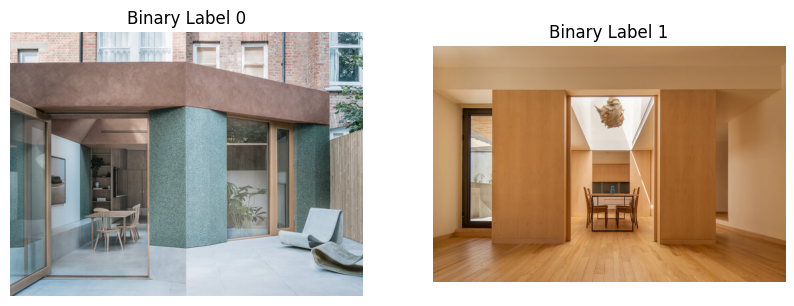

In [19]:
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
# Example: Loading the DataFrame (replace this with your actual DataFrame loading if needed)
# binary_df = pd.read_csv('your_dataset.csv')

# Select one image path for each binary label
img_path_label_0 = binary_df[binary_df['binary_label'] == 0].iloc[0]['image_path']
img_path_label_1 = binary_df[binary_df['binary_label'] == 1].iloc[0]['image_path']
img_path_label_1
# Open and display the images
img_0 = Image.open(img_path_label_0)
img_1 = Image.open(img_path_label_1)



# Load images
img_0 = Image.open(img_path_label_0)
img_1 = Image.open(img_path_label_1)

# Display images inline
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(img_0)
axs[0].set_title('Binary Label 0')
axs[0].axis('off')

axs[1].imshow(img_1)
axs[1].set_title('Binary Label 1')
axs[1].axis('off')

plt.show()


In [20]:
binary_df.shape

(129, 3)

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load images and prepare the data
def load_and_preprocess_images(df, target_size=(224, 224)):
    images = []
    labels = []
    for _, row in df.iterrows():
        img = load_img(row['image_path'], target_size=target_size)
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        images.append(img_array)
        labels.append(row['binary_label'])
    return np.array(images), np.array(labels)

# Load the binary classification data
X, y = load_and_preprocess_images(binary_df)

# Build the binary classifier
def build_binary_classifier(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary output
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize the model with the shape of the input images
binary_classifier = build_binary_classifier(X.shape[1:])

# Display the model summary
binary_classifier.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       9,633,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,635,969 (36.76 MB)

 Trainable params: 9,635,969 (36.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - accuracy: 0.4284 - loss: 10.6948 - val_accuracy: 0.8077 - val_loss: 9.0813
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 300ms/step - accuracy: 0.7103 - loss: 9.8932 - val_accuracy: 1.0000 - val_loss: 0.0082
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - accuracy: 0.9364 - loss: 0.2325 - val_accuracy: 1.0000 - val_loss: 8.3397e-07
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 1.0000 - loss: 1.8979e-06 - val_accuracy: 1.0000 - val_loss: 3.7092e-05
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 4.8569e-05
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 1.0000 - loss: 4.4647e-05 - val_accuracy: 1.0000 - val_loss: 3.6194e-08
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 1.0000 - loss: 1.9552e-08 - val_accuracy: 1.0000 - val_loss: 2.0812e-10
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 1.0000 - loss: 1.5416e-

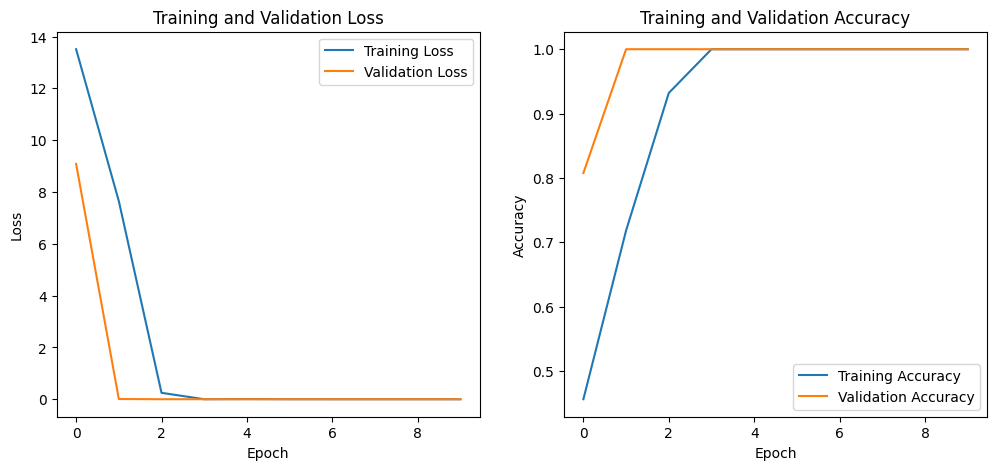

In [22]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

import matplotlib.pyplot as plt

# Train the binary classifier and store the training history
history = binary_classifier.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Plot the training and validation loss
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Call the function to plot the history
plot_training_history(history)



In [23]:
# Evaluate the model on the validation set
loss, accuracy = binary_classifier.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 4.2084e-13
Validation Loss: 4.208381418954049e-13, Validation Accuracy: 1.0


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 421ms/step - accuracy: 0.4875 - loss: 18.7850 - val_accuracy: 1.0000 - val_loss: 2.1856e-05
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.8441 - loss: 1.6774 - val_accuracy: 0.8077 - val_loss: 5.5146
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.8582 - loss: 0.7808 - val_accuracy: 1.0000 - val_loss: 3.8575e-14
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - accuracy: 0.9674 - loss: 0.5291 - val_accuracy: 0.8077 - val_loss: 1.0994
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.7472 - loss: 6.1519 - val_accuracy: 0.9615 - val_loss: 0.3954
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.9454 - loss: 0.5017 - val_accuracy: 1.0000 - val_loss: 1.3133e-16
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 275ms/step - accuracy: 0.9893 - loss: 0.1262 - val_accuracy: 1.0000 - val_loss: 5.7031e-13
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.9970 - loss: 0.0071 - val_accura

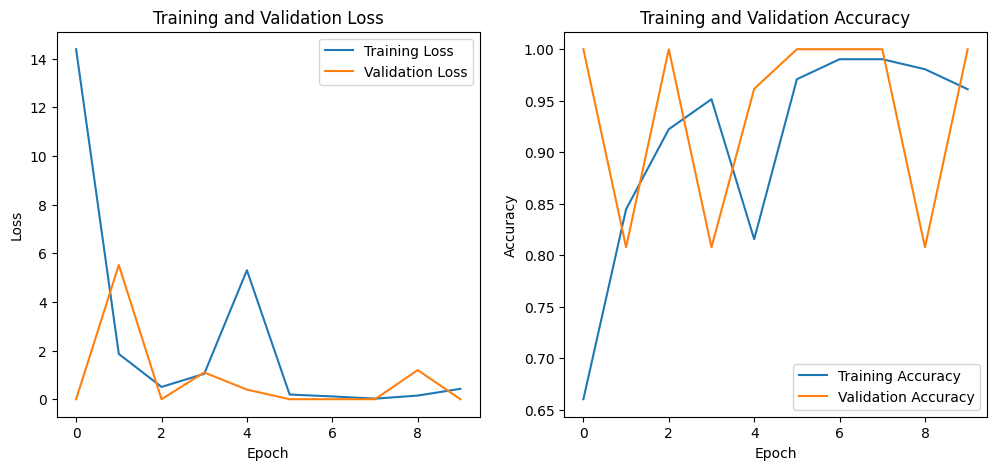

In [24]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

# Data Augmentation to enhance generalization
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Load images and prepare the data
def load_and_preprocess_images(df, target_size=(224, 224)):
    images = []
    labels = []
    for _, row in df.iterrows():
        img = tf.keras.preprocessing.image.load_img(row['image_path'], target_size=target_size)
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalize pixel values
        images.append(img_array)
        labels.append(row['binary_label'])
    return np.array(images), np.array(labels)

# Load the binary classification data
X, y = load_and_preprocess_images(binary_df)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply data augmentation only on the training set
train_generator = datagen.flow(X_train, y_train, batch_size=8)

# Build a binary classifier
def build_binary_classifier(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Binary output
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize the model with the shape of the input images
binary_classifier = build_binary_classifier(X_train.shape[1:])

# Train the model with augmented data
history = binary_classifier.fit(
    train_generator,
    epochs=10,
    validation_data=(X_val, y_val)
)

# Plot the training and validation loss/accuracy
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Call the function to plot the history
plot_training_history(history)
